# Loading Modules

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor
from what_where.main import init, MNIST
from what_where.where import RetinaFill, WhereShift, RetinaBackground, RetinaMask
from POLO.PYramid2 import cropped_pyramid, local_filter, get_K, log_gabor_transform
from POLO.PYramid2 import inverse_pyramid, get_K_inv, inverse_gabor
from utils import view_data
from typing import List, Tuple

In [12]:
#args.offset_std = 30
#args.contrast = 0.7

width = {'in': 32, 'out': 64}

n_levels = {'in': 3, 'out': 3} 

base_levels = 2

n_color = {'in': 3, 'out': 3}

color = True

color_mode= 'rgb' #'lab' # 'hsv' #True

r_min = {'in': width['in'] / 4, 'out': width['out'] / 4}

r_max = {'in': width['in'] / 2, 'out': width['out'] / 2}

n_sublevel = n_eccentricity = {'in': 2, 'out': 4}

n_azimuth = {'in': 16, 'out': 32}

n_theta = {'in': 8, 'out': 8}

n_phase = {'in': 1, 'out': 1}

do_mask = False

gauss = False






In [13]:
lg={}
for k in ['in', 'out']:
    pe = {'N_X': width[k], 'N_Y': width[k], 'do_mask': do_mask, 'base_levels':
              base_levels, 'n_theta': 0, 'B_sf': np.inf, 'B_theta': np.inf ,
          'use_cache': True, 'figpath': 'results', 'edgefigpath':
              'results/edges', 'matpath': 'cache_dir', 'edgematpath':
              'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
              14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}   

    lg[k] = LogGabor(pe)

In [14]:
K = {}
for k in ['in', 'out']:
    K[k] = get_K(width=width[k],
          n_sublevel = n_sublevel[k], 
          n_azimuth = n_azimuth[k], 
          n_theta = n_theta[k],
          n_phase = n_phase[k], 
          r_min = r_min[k], 
          r_max = r_max[k], 
          log_density_ratio = 2, 
          verbose=True,
          lg=lg[k])

i_sublevel, sf_0, radius 0 0.36067376022224085 8.0
i_sublevel, sf_0, radius 1 0.25503486164919736 11.31370849898476
K shape= torch.Size([32, 32, 2, 16, 8, 1])
K min max= tensor(-0.3125) tensor(1.)
i_sublevel, sf_0, radius 0 0.18033688011112042 16.0
i_sublevel, sf_0, radius 1 0.15164463602348005 19.027313840043536
i_sublevel, sf_0, radius 2 0.12751743082459868 22.62741699796952
i_sublevel, sf_0, radius 3 0.10722895046276856 26.908685288118864
K shape= torch.Size([64, 64, 4, 32, 8, 1])
K min max= tensor(-0.2759) tensor(1.)


In [15]:
K_inv={}
for k in ['in', 'out']:
    K_inv[k] = get_K_inv(K[k], 
                  width=width[k], 
                  n_sublevel = n_sublevel[k], 
                  n_azimuth = n_azimuth[k], 
                  n_theta = n_theta[k], 
                  n_phase = n_phase[k])

Filter tensor shape= torch.Size([32, 32, 2, 16, 8, 1])
Reshaped filter tensor= torch.Size([1024, 256])
Tensor shape= torch.Size([256, 1024])
Filter tensor shape= torch.Size([64, 64, 4, 32, 8, 1])
Reshaped filter tensor= torch.Size([4096, 1024])
Tensor shape= torch.Size([1024, 4096])


# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [16]:
args = init(filename='2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

In [17]:
class DualCroppedPyramid(object):
    def __init__(self, width, 
                 base_levels, 
                 color=color, 
                 do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb'):
        self.width = width
        self.base_levels = base_levels
        self.color = color
        self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode

    def __call__(self, img):
        img_crop = {}
        for k in ['in', 'out']:
            img_crop_part, level_size = cropped_pyramid(img.unsqueeze(0), 
                                               width=self.width[k], 
                                               base_levels=self.base_levels,
                                               color=self.color, 
                                               do_mask=self.do_mask, 
                                               verbose=self.verbose,
                                               squeeze=True,
                                               gauss=gauss,
                                               n_levels=self.n_levels[k],
                                               color_mode=self.color_mode)
            #print(img_crop_part.shape)
            img_crop[k] = img_crop_part[:self.n_levels[k]-1,...]
        return img, img_crop   

### LogGaborTransform

In [18]:
class DualLogGaborTransform(object):
    def __init__(self, K=K, color=color, verbose=False):
        self.K = K
        self.color = color
        self.verbose = verbose

    def __call__(self, cropped_pyr):
        img = cropped_pyr[0]
        img_crop = cropped_pyr[1]
        log_gabor_coeffs = {}
        for k in ['in', 'out']:
            log_gabor_coeffs[k] = log_gabor_transform(img_crop[k].unsqueeze(1), K[k], color=self.color).squeeze(1)
        
        return img, log_gabor_coeffs

In [19]:
class DualLogGaborReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose

    def __call__(self, log_gabor_transform):
        img = log_gabor_transform[0]
        log_gabor_coeffs = log_gabor_transform[1]
        for k in ['in', 'out']:
            # n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase
            # x      , 0       , 1      , 2         , 3        , 4      , 5
            # 
            #print(log_gabor_coeffs[k].shape)
            log_gabor_coeffs[k] = log_gabor_coeffs[k].permute(1, 4, 5, 0, 2, 3).contiguous()
            log_gabor_coeffs[k] = log_gabor_coeffs[k].view(self.n_color[k]*self.n_theta[k]*self.n_phase[k], 
                                                     (self.n_levels[k]-1) * self.n_eccentricity[k], 
                                                     self.n_azimuth[k])
 
        return img, log_gabor_coeffs

In [20]:
class LogGaborInvReshape(object):
    def __init__(self, n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color, verbose=False):
        self.n_levels = n_levels
        self.n_color = n_color
        self.n_eccentricity = n_eccentricity 
        self.n_azimuth = n_azimuth 
        self.n_theta = n_theta
        self.n_phase = n_phase  
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):

        if self.verbose:
            print('log_gabor_coeffs.shape:', log_gabor_coeffs.shape)
        log_gabor_coeffs = log_gabor_coeffs.view(-1, 
                                                 self.n_color, 
                                                 self.n_theta, 
                                                 self.n_phase, 
                                                 self.n_levels, 
                                                 self.n_eccentricity, 
                                                 self.n_azimuth)
        log_gabor_coeffs = log_gabor_coeffs.permute(0, 4, 1, 5, 6, 2, 3).contiguous()
        return log_gabor_coeffs

In [21]:
class LogGaborInvTransform(object):
    def __init__(self, K_inv=K_inv, color=color, verbose=False):
        self.K_inv = K_inv
        self.color = color
        self.verbose = verbose
    
    def __call__(self, log_gabor_coeffs):
        img_crop=inverse_gabor(log_gabor_coeffs[:, :, 0, ...].detach(), self.K_inv, self.verbose)
        if self.verbose:
            print('img_crop.shape:', img_crop.shape)

        return img_crop

In [22]:
class InvCroppedPyramid(object):
    def __init__(self, 
                 #width, 
                 base_levels, 
                 color=color, 
                 #do_mask=do_mask, 
                 verbose=False, 
                 n_levels=None, 
                 color_mode='rgb',
                 N_X = 128,
                 N_Y = 128):
        #self.width = width
        self.base_levels = base_levels
        self.color = color
        #self.do_mask = do_mask
        self.verbose = verbose
        self.n_levels = n_levels
        self.color_mode = color_mode
        self.N_X = N_X
        self.N_Y = N_Y

    def __call__(self, img_crop):
        full_img_rec = inverse_pyramid(img_crop, 
                                       N_X = self.N_X,
                                       N_Y = self.N_Y,
                                       #width=self.width, 
                                       base_levels=self.base_levels,
                                       color=self.color, 
                                       #do_mask=self.do_mask, 
                                       verbose=self.verbose,
                                       #squeeze=True,
                                       gauss=gauss,
                                       n_levels=self.n_levels) #,
                                       #color_mode=self.color_mode)
        return full_img_rec

### Inverse transformations (for display only)

# Exploring the MNIST with where noise parameters and log polar encoding

- 128x128 pixel with shift, noise and circular mask

In [23]:
#args.offset_max = 40 #like in the paper

In [24]:
# normalization used to train VGG
# see https://pytorch.org/hub/pytorch_vision_vgg/
v_mean = np.array([0.485, 0.456, 0.406])
v_std = np.array([0.229, 0.224, 0.225])
transforms_norm = transforms.Normalize(mean=v_mean, std=v_std) # to normalize colors on the imagenet dataset



In [25]:
image_size = 256

transform_big =  transforms.Compose([
            transforms.Resize((int(image_size), int(image_size))),
            #transforms.AutoAugment(), # https://pytorch.org/vision/master/transforms.html#torchvision.transforms.AutoAugment
            transforms.ToTensor(),      # Convert the image to pyTorch Tensor data type.
            #transforms_norm, 
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [26]:
width,base_levels, color, n_levels

({'in': 32, 'out': 64}, 2, True, {'in': 3, 'out': 3})

In [27]:
image_path = "/media/manu/Seagate Expansion Drive/Data/animal/"

image_dataset = { 'train' : datasets.ImageFolder(
                            image_path+'train', 
                            transform=transform_big
                        ),
                  'test' : datasets.ImageFolder(
                            image_path+'test', 
                            transform=transform_big
                        )
                }

In [28]:
dataset_size = {'train' : len(image_dataset['train']),
                'test' : len(image_dataset['test'])}

dataset_size['train'], dataset_size['test']

(20000, 4000)

In [29]:
batch_size = 50
num_workers = 1

dataloader = { 'train' : torch.utils.data.DataLoader(
                            image_dataset['train'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [30]:
data, label = next(iter(dataloader['train']))

In [31]:
data_original = data[0]
data_polo = data[1]
data_original.shape, data_polo['in'].shape, data_polo['out'].shape

(torch.Size([50, 3, 256, 256]),
 torch.Size([50, 24, 4, 16]),
 torch.Size([50, 24, 8, 32]))

In [32]:
# n_batch, n_levels, n_color, n_sublevel, n_azimuth, n_theta, n_phase

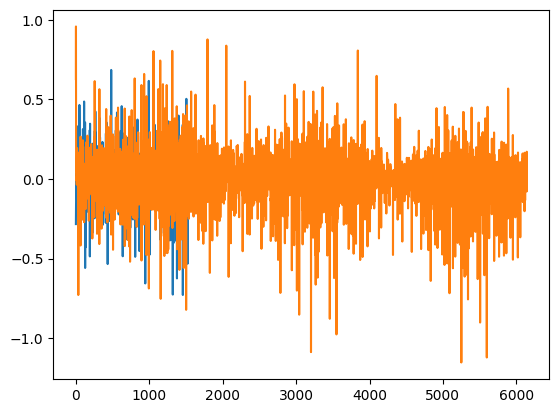

In [33]:
plt.plot(data_polo['in'][3,...].detach().numpy().flatten())
plt.plot(data_polo['out'][3,...].detach().numpy().flatten())


### Displaying Log Gabor Encoded visual field using pseudo-inverse transformation

In [34]:
inverse_transform = {}
for k in ['in', 'out']:
    N_X = N_Y = width[k] * 2**(n_levels[k]-1)
    print(N_X)
    inverse_transform[k] = transforms.Compose([
        LogGaborInvReshape(n_levels[k], n_color[k], n_eccentricity[k], n_azimuth[k], n_theta[k], n_phase[k], color=color, verbose=False),        
        LogGaborInvTransform(K_inv=K_inv[k], color=color, verbose=False),
        InvCroppedPyramid(base_levels, n_levels=n_levels[k], verbose=False, N_X=N_X, N_Y=N_Y),
    ])

128
256


- The Log-Polar compressed format

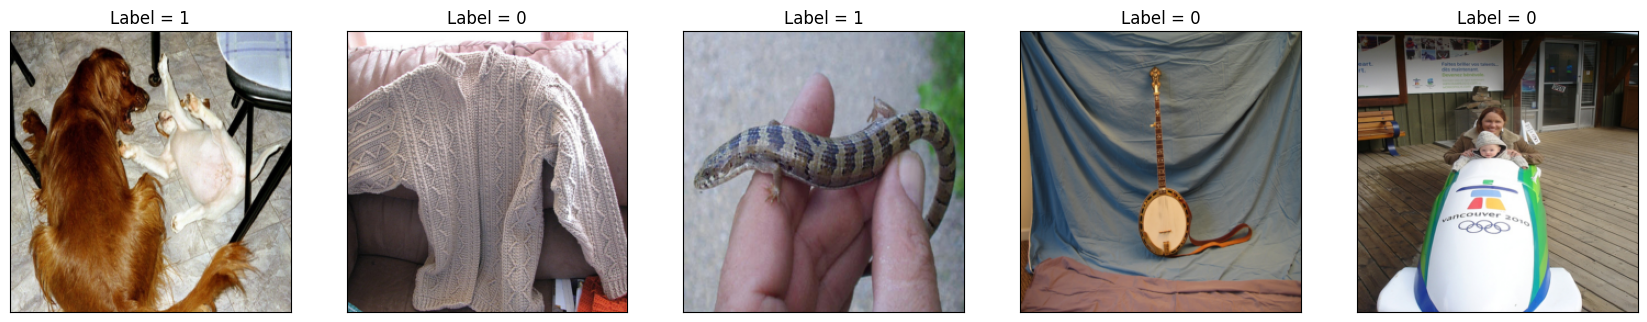

In [35]:
original = view_data(data_original, label, 5)

In [36]:
inverse_transform['in']

Compose(
)

b = {'in':32,'out':64}
for k in ['in', 'out']:
    data = torch.cat((data_polo[k],torch.zeros_like(data_polo[k][:,:1,...])), dim=1) 
    full_img_rec = inverse_transform[k](data)
    img_aff = full_img_rec[:,:,b[k]:-b[k],b[k]:-b[k]]
    _ = view_data(img_aff, label, 5)
    if k == 'in':
        img_sum = full_img_rec
    else:
        img_sum += img_aff
_ = view_data(img_sum, label, 5)

- The original format

In [37]:
data_polo['in'].shape, data_polo['out'].shape

(torch.Size([50, 24, 4, 16]), torch.Size([50, 24, 8, 32]))

# Creating an Attention Transformer model with log-polar entry (POLO-STN)

In [38]:
transform_in =  transforms.Compose([
            DualCroppedPyramid(width=width, 
                  base_levels=base_levels,
                  color=color,
                  n_levels=n_levels),
            DualLogGaborTransform(K=K, color=color),
            DualLogGaborReshape(n_levels, n_color, n_eccentricity, n_azimuth, n_theta, n_phase, color=color),
        ])

In [39]:
def negentropy_loss(model, z):
    z_mean = torch.mean(z, dim=0)
    z_std = torch.std(z, dim=0)
    p = torch.distributions.Normal(torch.ones_like(z)*z_mean, torch.ones_like(z) * z_std)
    return .3 * model.LAMBDA * p.log_prob(z).sum()

In [40]:
def kl_divergence(model, z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), args.std_sched * torch.ones_like(std))

    # 2. get the probabilities from the equation
    log_qzx = model.q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    
    # sum over last dim to go from single dim distribution to multi-dim
    kl = model.LAMBDA * kl.sum()
    return kl

In [41]:
class Polo_AttentionTransNet(nn.Module):
    
    def __init__(self, do_stn=True, do_what=False, deterministic=False, LAMBDA=.1):
        super(Polo_AttentionTransNet, self).__init__()
        
        self.do_stn = do_stn
        self.do_what = do_what
        self.deterministic = deterministic
        
        self.LAMBDA = LAMBDA

        ##  The what pathway
        self.wloc1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              50, 3, padding=1)
        self.wloc2a = nn.Conv2d(50, 100, 3, padding=1)
        self.wloc2b = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               50, 3, padding=1)
        self.wloc3 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100), 
                              500)
        self.wloc4 = nn.Linear(500, 2)

        #self.wloc4.weight.data.zero_()
        #self.wloc4.bias.data.zero_()

                
        ##  The where pathway        
        self.loc1 = nn.Conv2d(n_color['out'] * n_theta['out'] * n_phase['out'], 
                              50, 5, padding=2, stride=2)
        self.loc2a = nn.Conv2d(50, 100, 5, padding=2,stride=2)
        self.loc2b = nn.Conv2d(n_color['in'] * n_theta['in'] * n_phase['in'], 
                               50, 5, padding=2,stride=2)
        self.loc3 = nn.Linear((n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2 * (50+100), 
                              500)
        self.mu = nn.Linear(500, 2, bias=False)
        self.logvar = nn.Linear(500, 2, bias=False)
        
        

        #self.loc4.weight.data.zero_()
        #self.loc4.bias.data.zero_()

        self.downscale = nn.Parameter(torch.tensor([[1, 0], [0, 1]],
                                                   dtype=torch.float),
                                      requires_grad=False)

    def stn(self: object, x: torch.Tensor, x_polo: torch.Tensor) -> Tuple[torch.Tensor]:
    
        if self.do_stn:
            xs_part = {}
            #for k in ['in', 'out']:
            #    print(x_polo[k].shape)
            #    xs_part[k] = x_polo[k].permute(0,2,5,6,1,3,4)
            #    xs_part[k] = xs_part[k].view(-1, n_color[k] * n_theta[k] * n_phase[k], 
            #                                 (n_levels[k]-1) * n_eccentricity[k], 
            #                                 n_azimuth[k])

            #print(x_polo['out'].shape)

            if True: #with torch.no_grad():
                xs = F.relu(self.loc1(x_polo['out']))

                xsa = F.relu(self.loc2a(xs))

                xsb = F.relu(self.loc2b(x_polo['in']))
                
                xs = torch.cat((xsa, xsb), dim=1)
            xs = F.relu(self.loc3(xs.view(-1, 
                                          (50+100) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
            #theta = F.sigmoid(self.loc4(xs)) - 0.5
            #theta = self.loc4(xs)
            mu = self.mu(xs)
            if self.deterministic:
                sigma = .1 * torch.ones_like(mu)  
                self.q = torch.distributions.Normal(mu, sigma)  
                z = mu
            else:
                logvar = self.logvar(xs) + 6
                sigma = torch.exp(-logvar / 2)
                self.q = torch.distributions.Normal(mu, sigma)      
                z = self.q.rsample()
            
            print(z[0,...])
            theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
            grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
            grid = F.affine_grid(theta, grid_size)
            x = F.grid_sample(x, grid)

        else:
            mu = torch.tensor([0, 0],dtype=torch.double)
            mu = mu.unsqueeze(0).repeat(x.size()[0], 1)   
            sigma = torch.tensor([1, 1],dtype=torch.double)
            sigma = sigma.unsqueeze(0).repeat(x.size()[0], 1)    
            
            if self.do_what:
                self.q = torch.distributions.Normal(mu, 0.3*sigma)
                z = self.q.rsample()
                print(z[0,...])
                theta = torch.cat((self.downscale.unsqueeze(0).repeat(
                                z.size(0), 1, 1), z.unsqueeze(2)),
                                  dim=2)
        
                grid_size = torch.Size([x.size()[0], x.size()[1], 256, 256])
                grid = F.affine_grid(theta, grid_size)
                x = F.grid_sample(x, grid)
            else:
                z = torch.tensor([0, 0],dtype=torch.float)
                z = z.unsqueeze(0).repeat(x.size()[0], 1)

                theta = nn.Parameter(torch.tensor([[1, 0, 0], [0, 1, 0]],
                                                    dtype=torch.float),
                                        requires_grad=False)
                theta = theta.unsqueeze(0).repeat(x.size()[0], 1, 1)
            
              
        return x, theta, z, mu, sigma

    def forward(self, x, x_polo):
        # transform the input
        x, theta, z, mu, sigma = self.stn(x, x_polo)
        
        if self.do_stn:
        
            w_x_polo ={'in': torch.zeros_like(x_polo['in']),
                       'out': torch.zeros_like(x_polo['out'])}
            for i in range(args.batch_size):
                d, w = transform_in(x[i,...])
                w_x_polo['in'][i,...] = w['in']
                w_x_polo['out'][i,...] = w['out']
        else:
            w_x_polo = x_polo
                                           

        # print(x.shape)
        # Perform the usual forward pass
        ya = F.relu(self.wloc1(w_x_polo['out']))
        ya = nn.MaxPool2d(2)(ya)        
        
        #print(xs.shape)
        
        ya = F.relu(self.wloc2a(ya))
        ya = nn.MaxPool2d(2)(ya)
        
        #print(xsa.shape)
        
        yb = F.relu(self.wloc2b(w_x_polo['in']))
        yb = nn.MaxPool2d(2)(yb)
        
        #print(xsb.shape)

        y = torch.cat((ya, yb), dim=1)
        y = F.relu(self.wloc3(y.view(-1, (50+100) * (n_levels['in']-1) * n_eccentricity['in'] // 2 * n_azimuth['in'] // 2)))
        y = self.wloc4(y)
        return y, theta, z, mu, sigma

In [42]:
LAMBDA = 1e-4
deterministic = True


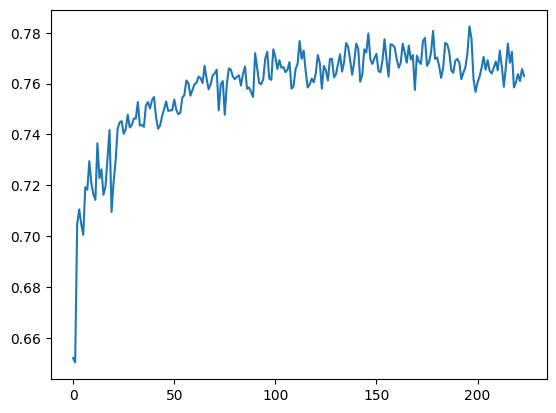

In [43]:
acc = np.load("230217_polo_stn_dual_lambda_0.0001_mixed_acc.npy")
plt.plot(acc)

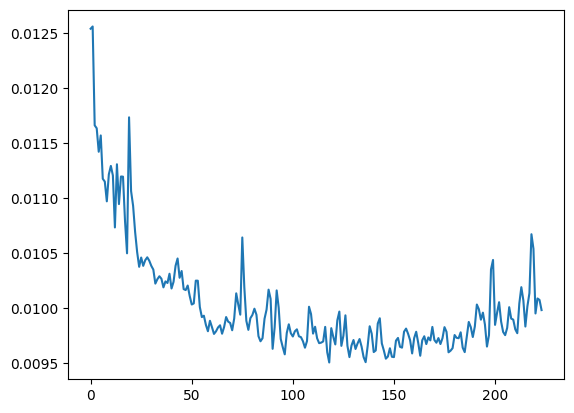

In [44]:
loss = np.load("230217_polo_stn_dual_lambda_0.0001_mixed_loss.npy")
plt.plot(loss)

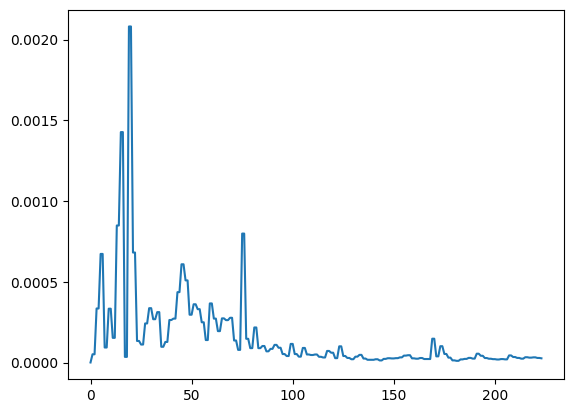

In [45]:
kl_loss = np.load("230217_polo_stn_dual_lambda_0.0001_mixed_kl_loss.npy")
plt.plot(kl_loss)

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Polo_AttentionTransNet(LAMBDA=LAMBDA, deterministic=deterministic).to(device)
model = torch.load("230217_polo_stn_dual_lambda_0.0001_mixed.pt")

In [47]:
data, label = next(iter(dataloader['train']))

In [48]:
output = model.stn(data[0], data[1])

tensor([ 0.0943, -0.0794], grad_fn=<SelectBackward0>)


In [49]:
num=1
args.batch_size = batch_size
with torch.no_grad():
    cat = model(data[0], data[1])
cat = torch.argmax(F.softmax(cat[0]),1)

tensor([ 0.0943, -0.0794])


In [50]:
cat

tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0])

In [51]:
output[0].shape

torch.Size([50, 3, 256, 256])

[ 0.09434157 -0.07942404]
[0.2072103  0.12460769]
[0.01967135 0.04119434]
[-0.04285739 -0.01154999]
[-0.03174247  0.01622807]
[ 0.01488485 -0.0622649 ]
[-0.01243108  0.12913046]
[0.04574743 0.00533361]
[-0.01057361 -0.01714384]
[-0.06714625 -0.10439347]
[-0.04886524 -0.07963614]
[0.13207693 0.10995253]
[-0.01606962  0.00356986]
[-0.02517229 -0.03457116]
[-0.02299857  0.00684569]
[0.01316783 0.01966736]
[-0.03578713  0.03567801]
[-0.04562885  0.01301869]
[0.01808933 0.01028717]
[-0.00587492  0.01711008]


/tmp/ipykernel_3552/3119125566.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,10))


[ 0.05973389 -0.00509746]
[-0.02375827  0.0061238 ]
[ 0.00508207 -0.03184097]
[-0.02394621 -0.01372251]
[-0.01289454  0.01629265]
[-0.03672893 -0.02009473]
[-0.07974187  0.00111206]
[0.04404337 0.00336578]
[-0.03044241 -0.01726794]
[-0.0133614   0.02010677]
[-0.09232769  0.073894  ]
[ 0.01698489 -0.00291084]
[ 0.01015115 -0.00304556]
[-0.04298756 -0.01364524]
[0.01328469 0.01764076]
[-0.12139924  0.03342701]
[0.00580577 0.05495594]
[ 0.0305295  -0.09690429]
[0.04490832 0.03006944]
[-0.02727282  0.00494213]
[0.06019849 0.09015404]
[-0.00171428 -0.00231898]
[0.08377232 0.0790992 ]
[0.13965541 0.10767402]
[-0.0173858   0.00850189]
[ 0.00442222 -0.02604245]
[-0.00783782  0.0287914 ]
[ 0.0341994  -0.04639739]
[-0.07456987 -0.04123783]
[-0.00206591 -0.07756901]


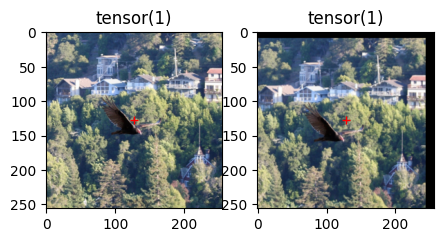

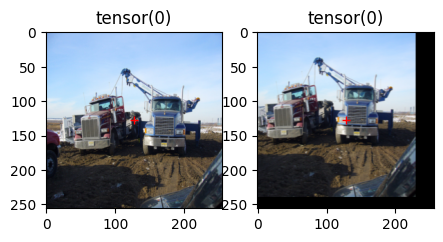

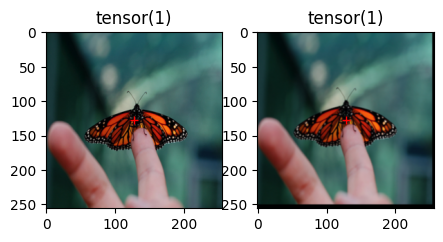

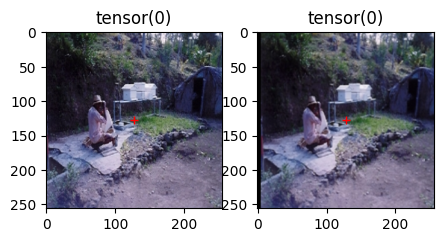

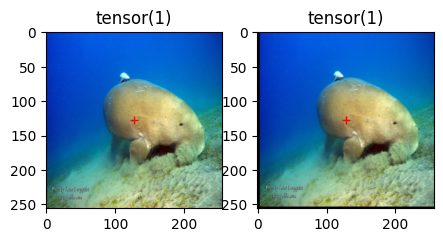

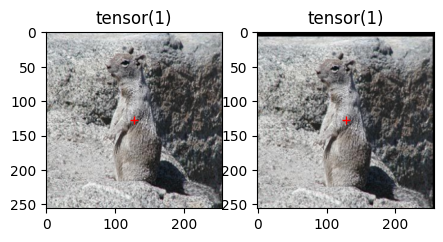

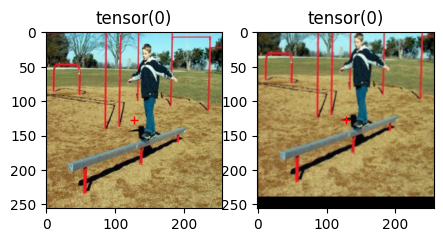

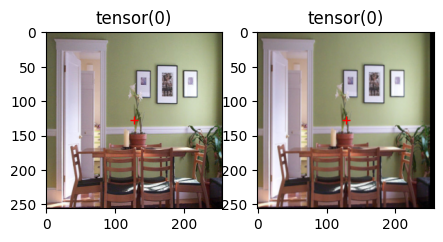

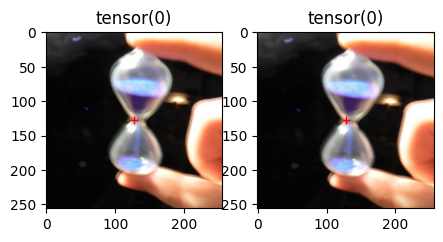

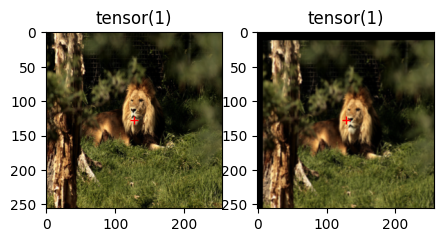

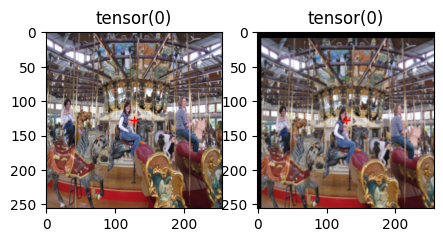

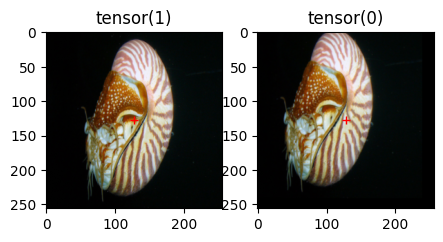

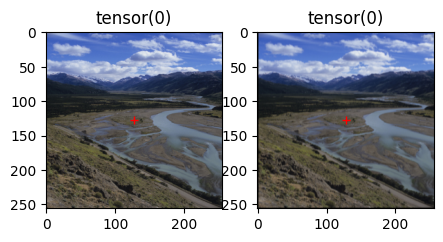

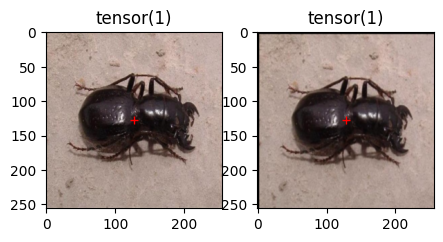

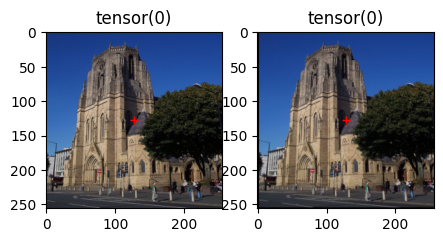

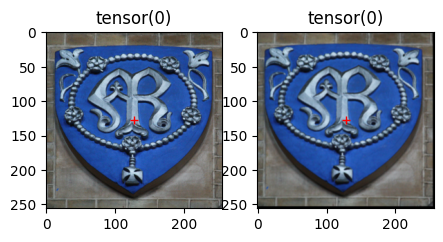

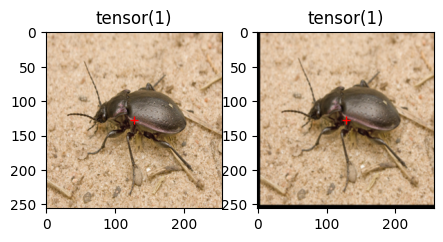

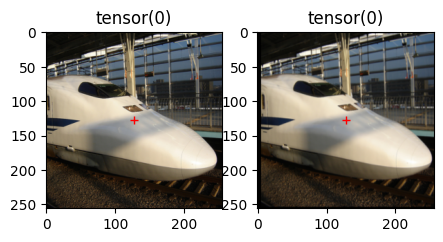

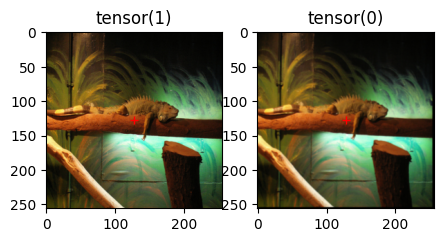

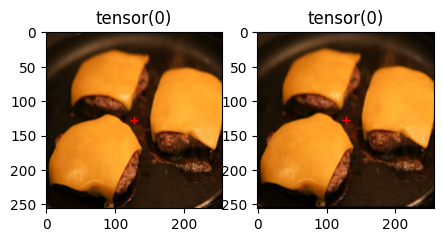

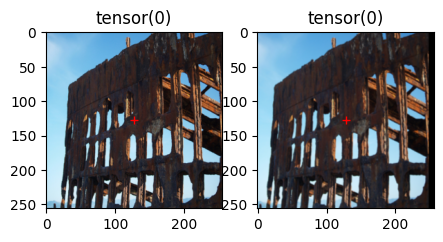

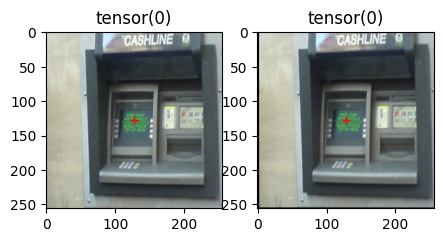

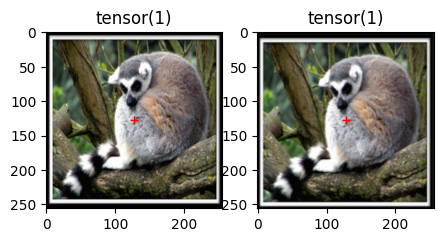

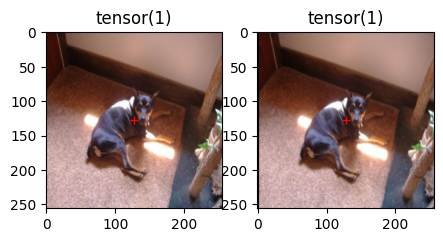

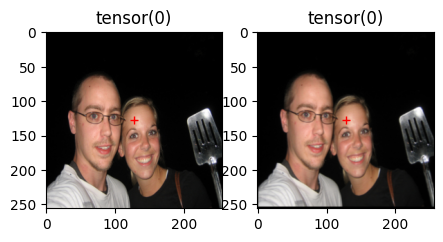

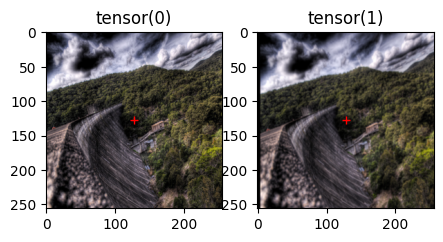

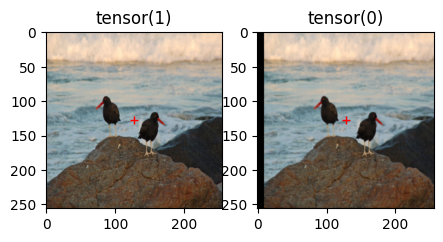

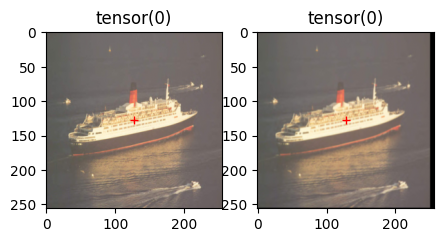

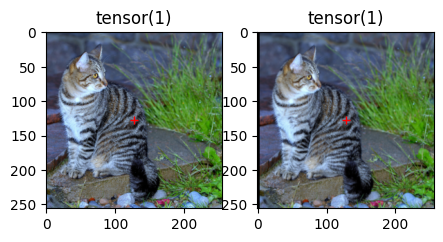

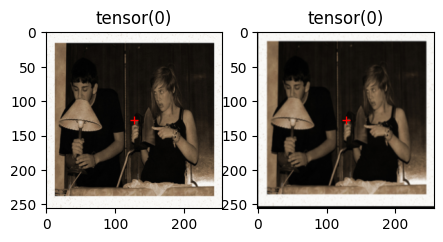

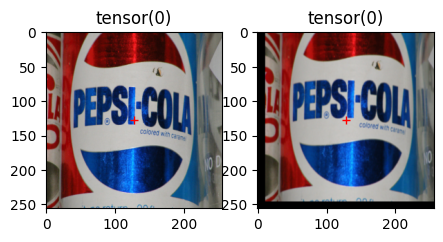

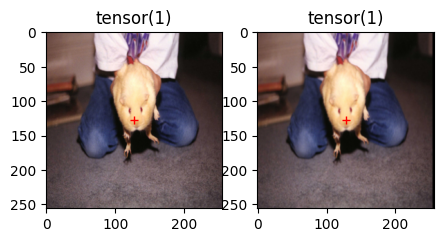

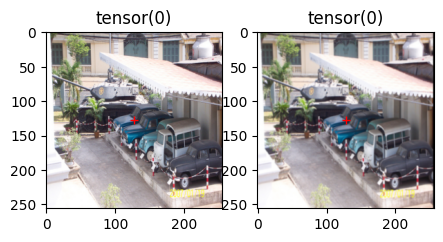

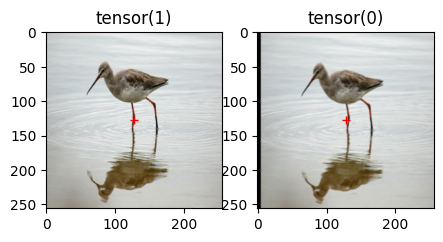

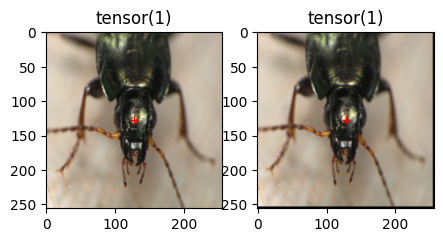

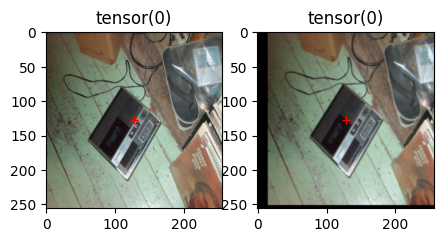

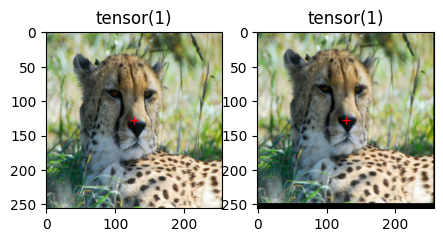

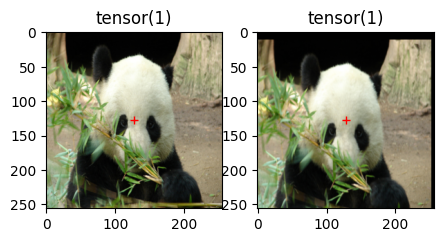

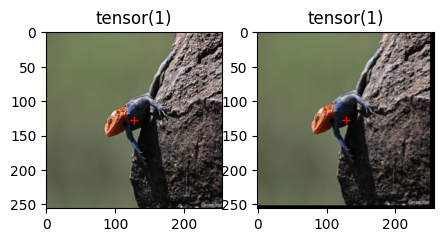

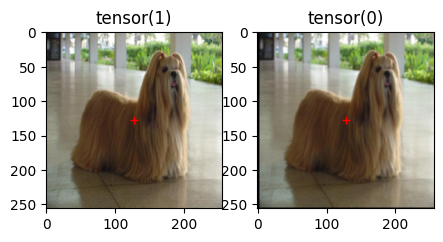

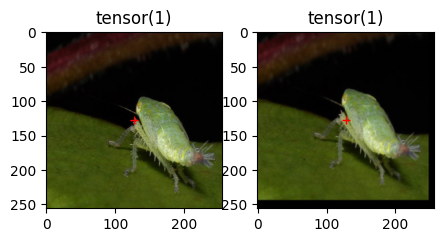

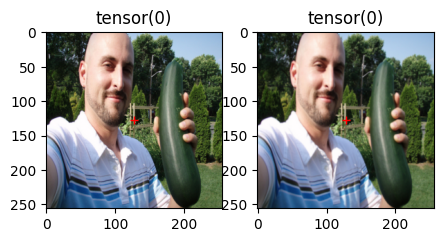

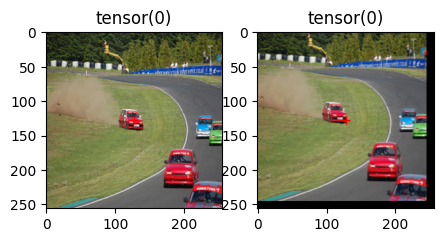

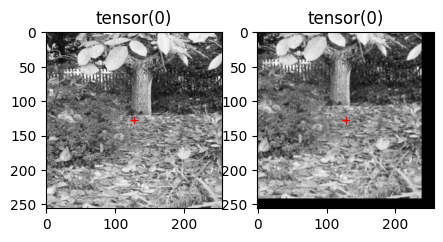

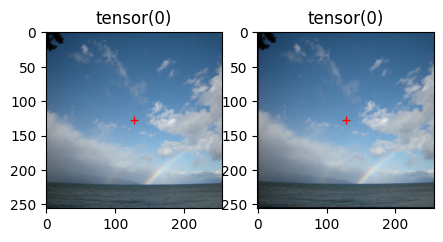

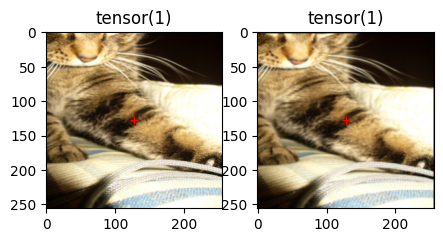

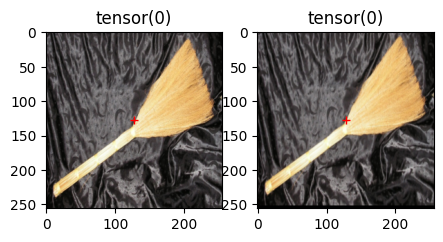

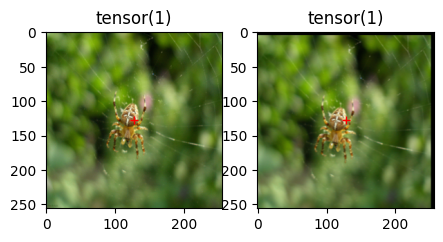

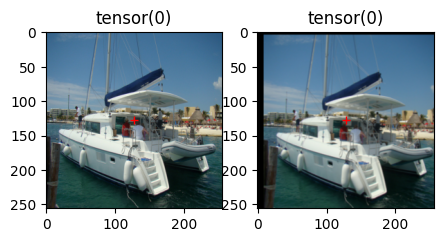

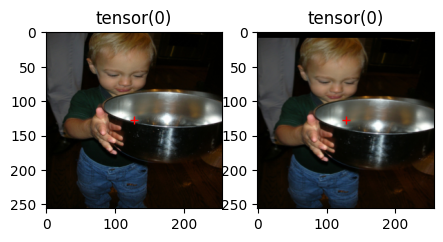

In [52]:
#theta = torch.cat((model.downscale.unsqueeze(0).repeat(
#            theta.size(0), 1, 1), theta.unsqueeze(2)),
#                          dim=2)
        
        #theta = theta.view(-1, 2, 3)
for num in range(50):
        plt.figure(figsize=(5,10))
        plt.subplot(1,2,1)
        img = data[0][num:num+1,...]   
        theta = output[1][num:num+1,...]
        #theta[0,:,2] = torch.FloatTensor((0,.5))
        print(theta[0,:,2].detach().numpy())
        grid_size = torch.Size([1, 3, 256, 256])
        grid = F.affine_grid(theta, grid_size)
        img_grid = F.grid_sample(img, grid)
        plt.imshow(data[0][num,...].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(label[num])
        plt.subplot(1,2,2)
        plt.imshow(img_grid[0,:].permute(1,2,0).detach().numpy())
        plt.plot(127.5, 127.5, 'r+')
        plt.title(cat[num])

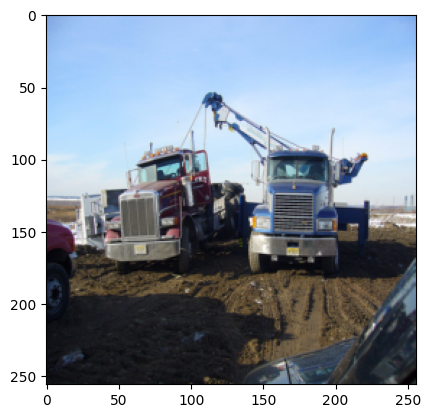

In [53]:
plt.imshow(data[0][1,:].permute(1,2,0).detach().numpy())

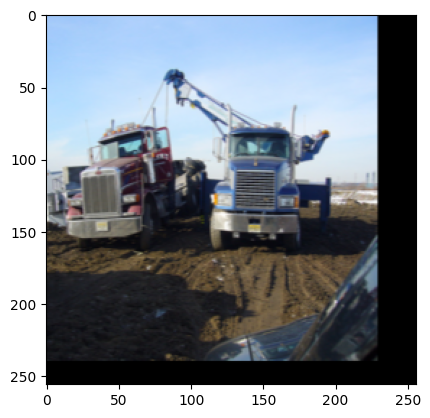

In [54]:
plt.imshow(output[0][1,:].permute(1,2,0).detach().numpy())

In [55]:
output[1][1][:,2].detach().numpy()

array([0.2072103 , 0.12460769])